# Investigating Generalisation Using Tree Methods


In this short section we use off-the-shelf tree methods to highlight a common problem often overlooked in the specific domain of AI generated text detection in essays. The problem is that there is very poor generalization between datasets for models, especially when there is differences in the essay topic or in the LLM that generated the AI text. Here, we demonstrate how easy it is to get accurate classification with out of the box models when trained on essays from a specific topic and we investigate how these models generalise.

## Import and Explaination of Datasets

To demonstrate the generalisation we use 2 different datasets. Firstly the "main" dataset found at https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset/data which we use throughout the group project. This contains human and AI generated essays on a variety of topics given by a variety of LLMs which means we would expect it to be a fairly good, generalised dataset for the problem we are tackling.

The second dataset is a small one generated with only two prompts and it is comprised of 3 different kaggle datasets. the first is the train_essays.csv found at https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data, as this dataset only has 3 AI generated texts we combine it with two datasets found at https://www.kaggle.com/datasets/radek1/llm-generated-essays which consists of 500 gpt-3.5-turbo essays and 200 gpt-4 essays on the same two prompts. Combining these datasets gives us a dataset of 2000 entries. This is useful for us as we can treat it as a real world example where we have a group of students answering the same question and we need to classify the AI cases where the students have cheated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('train_essays_kagglecomp.csv')
df2 = pd.read_csv('AI_essays_on_prompts_gpt3.csv')
df3 = pd.read_csv('AI_essays_on_prompts_gpt4.csv')


maindf = pd.read_csv('Main dataset.csv')

data = df.to_numpy()
data2 = df2.to_numpy()
data3 = df3.to_numpy()

maindata = maindf.to_numpy()

In [2]:
essays = np.concatenate((data, data2))
essays = np.concatenate((essays, data3))

## Feature Development

Below we engineer 22 features from the essays, the features selected are very similar to those selected in the paper "Distinguishing academic science writing from humans or ChatGPT with over 99% accuracy using off-the-shelf machine learning tools" available at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10328544/.
The features are average word length, average words per paragraph, average and standard deviation in sentence length, average difference between consecutive sentences, counts for sentences over 34 words or under 11 words, counts for the apprences of the punctuation ")", "!", "?", ":", ";", ",", "-", "'" and counts for the words "and", "but", "however", "therefore", "although", "this", and "because". It is clear to see there is much more possible exploration to put into feature analysis and engineering which could improve results. The primative feature development here could be one of the main reasons for the poor generalisation of model results between different datasets.

In [3]:
def average_word_length(input_string):
    words = input_string.split()  # Split the string into a list of words
    total_characters = sum(len(word) for word in words)
    total_words = len(words)

    if total_words == 0:
        return 0  # Avoid division by zero if the input string is empty

    avg_length = total_characters / total_words
    return avg_length

In [4]:
def average_words_per_paragraph(text):
    paragraphs = text.split('\n\n')  # Split the text into paragraphs
    total_words = 0
    total_paragraphs = len(paragraphs)

    for paragraph in paragraphs:
        words = paragraph.split()  # Split each paragraph into words
        total_words += len(words)

    if total_paragraphs == 0:
        return 0  # Avoid division by zero if the input text has no paragraphs

    avg_words_per_paragraph = total_words / total_paragraphs
    return avg_words_per_paragraph

In [5]:
import re
import statistics

def sentence_stats(text):
    # Use regular expression to split the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Remove empty strings from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Calculate the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Calculate the average sentence length
    avg_sentence_length = statistics.mean(sentence_lengths)

    # Calculate the standard deviation in sentence length
    if len(sentence_lengths) > 1:
        std_dev_sentence_length = statistics.stdev(sentence_lengths)
    else:
        std_dev_sentence_length = 0

    return avg_sentence_length, std_dev_sentence_length

In [6]:
def average_sentence_length_difference(text):
    # Use regular expression to split the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Remove empty strings from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Calculate the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Calculate the difference in consecutive sentence lengths
    sentence_length_diff = [abs(sentence_lengths[i] - sentence_lengths[i - 1]) for i in range(1, len(sentence_lengths))]

    # Calculate the average difference in consecutive sentence lengths
    avg_sentence_length_diff = statistics.mean(sentence_length_diff) if sentence_length_diff else 0

    return avg_sentence_length_diff

In [7]:
def count_sentences_by_length(text):
    # Use regular expression to split the text into sentences
    sentences = re.split(r'[.!?]', text)

    # Remove empty strings from the list of sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Count sentences with less than 11 words and more than 34 words
    count_less_than_11 = sum(1 for sentence in sentences if len(sentence.split()) < 11)
    count_more_than_34 = sum(1 for sentence in sentences if len(sentence.split()) > 34)

    return count_less_than_11, count_more_than_34

In [8]:
punctuation_marks = [")", "!", "?", ":", ";", ",", "-", "'"]
def count_punctuation(text, mark):
    punctuation_count = 0

    # Count the appearances of each punctuation mark
    for char in text:
        if char == mark:
            punctuation_count += 1

    return punctuation_count

In [9]:
key_words = ["and", "but", "however", "therefore", "although", "this", "because"]
def count_keyword(text, word):
    lower_case = text.lower()
    
    count = lower_case.split().count(word)

    return count

In [10]:
def feature_appender(dataset, text_index):
    features = []
    for essay in dataset:
        new_entry = []
        av_word_len = average_word_length(essay[text_index])
        new_entry.append(av_word_len)

        av_word_para = average_words_per_paragraph(essay[text_index])
        new_entry.append(av_word_para)

        mean_sentence_len, sd_sentence_len = sentence_stats(essay[text_index])
        new_entry.append(mean_sentence_len)
        new_entry.append(sd_sentence_len)

        consec_sen_diff = average_sentence_length_difference(essay[text_index])
        new_entry.append(consec_sen_diff)

        less_than_11, over_34 = count_sentences_by_length(essay[text_index])
        new_entry.append(less_than_11)
        new_entry.append(over_34)

        # appends 8 punctuation counts
        for punc in punctuation_marks:
            count = count_punctuation(essay[text_index], punc)
            new_entry.append(count)

        # appends 7 trigger words
        for word in key_words:
            count = count_keyword(essay[text_index], word)
            new_entry.append(count)
        features.append(new_entry)
        
    return features

In [11]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
%matplotlib inline

To start the analysis we first train on the small dataset that only has 2 prompts and then see how the models generalise when tested with essays generated by multiple prompts.

In [12]:
X_features = []
X_features = feature_appender(essays, 2)

In [13]:
y_list = []
for essay in essays:
    y_list.append(essay[3])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_list, test_size=0.2, random_state=42)

In [15]:
# Create Models
DT = DecisionTreeClassifier(random_state = 1)
RF = RandomForestClassifier(random_state = 1)
GBT = GradientBoostingClassifier(random_state = 1)
XGB = XGBClassifier(random_state = 1)

# Train models
DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
GBT.fit(X_train, y_train)
XGB.fit(X_train, y_train)

# Make predictions
DTpredicted = DT.predict(X_test)
RFpredicted = RF.predict(X_test)
GBTpredicted = GBT.predict(X_test)
XGBpredicted = XGB.predict(X_test)

In [16]:
# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Trees', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, DTpredicted), accuracy_score(y_test, RFpredicted), accuracy_score(y_test, GBTpredicted), accuracy_score(y_test, XGBpredicted)],
    'Precision': [precision_score(y_test, DTpredicted, average='weighted'), precision_score(y_test, RFpredicted, average='weighted'), precision_score(y_test, GBTpredicted, average='weighted'), precision_score(y_test, XGBpredicted, average='weighted')],
    'Recall': [recall_score(y_test, DTpredicted, average='weighted'), recall_score(y_test, RFpredicted, average='weighted'), recall_score(y_test, GBTpredicted, average='weighted'), recall_score(y_test, XGBpredicted, average='weighted')],
    'F1 Score': [f1_score(y_test, DTpredicted, average='weighted'), f1_score(y_test, RFpredicted, average='weighted'), f1_score(y_test, GBTpredicted, average='weighted'), f1_score(y_test, XGBpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Trees,0.997596,0.997605,0.997596,0.997594
1,Random Forest,0.997596,0.997605,0.997596,0.997594
2,Gradient Boosting,0.997596,0.997605,0.997596,0.997594
3,XGBoost,0.997596,0.997605,0.997596,0.997594


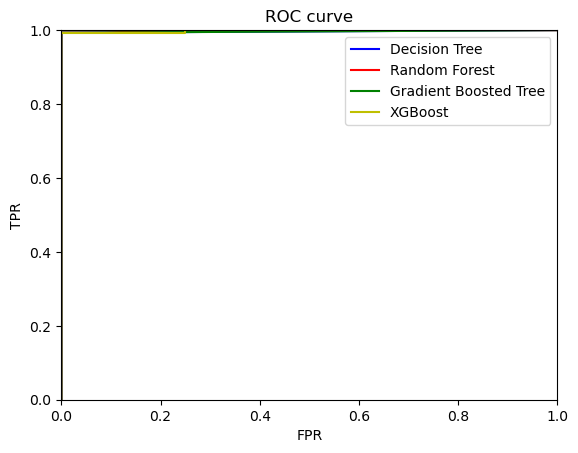

In [17]:
# Calculate probabilities
DTpredicted_probs = DT.predict_proba(X_test)
RFpredicted_probs = RF.predict_proba(X_test)
GBTpredicted_probs = GBT.predict_proba(X_test)
XGBpredicted_probs = XGB.predict_proba(X_test)

DT_fpr, DT_tpr, _ = roc_curve(y_test, DTpredicted_probs[:,1])
RF_fpr, RF_tpr, _ = roc_curve(y_test, RFpredicted_probs[:,1]) 
GBT_fpr, GBT_tpr, _ = roc_curve(y_test, GBTpredicted_probs[:,1])
XGB_fpr, XGB_tpr, _ = roc_curve(y_test, XGBpredicted_probs[:,1])

plt.plot(DT_fpr, DT_tpr, 'b', label="Decision Tree")
plt.plot(RF_fpr, RF_tpr, 'r', label="Random Forest")
plt.plot(GBT_fpr, GBT_tpr, 'g', label="Gradient Boosted Tree")
plt.plot(XGB_fpr, XGB_tpr, 'y', label="XGBoost")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()

In [18]:
ROCresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC-AUC Score': [roc_auc_score(y_test, DTpredicted_probs[:,1]), roc_auc_score(y_test, RFpredicted_probs[:,1]), roc_auc_score(y_test, GBTpredicted_probs[:,1]), roc_auc_score(y_test, XGBpredicted_probs[:,1])],
    
}
ROCresults_df = pd.DataFrame(ROCresults)
display(ROCresults_df)

,Method,ROC-AUC Score
0,Decision Tree,0.996528
1,Random Forest,0.998915
2,Gradient Boosting,0.996426
3,XGBoost,0.998264


As we can see from the different evaluation metrics, the models are performing extremely well. This is likely because many of the GPT essays will be very similar as they were generated by only two prompts and so our feature engineerig is enough to distinguish these from the human essays. We want our model to be able to generalise detect AI generated text in any subject. To see if this is possible for these models we now make predictions on the "main" and "drcat" datasets.

These results are inline with those found at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10328544/ which is encouraging as this is also quite a specific application.

In [19]:
drcat1_features = []
drcat1_features = feature_appender(maindata, 0)

In [20]:
drcat1_ylist = []
for essay in maindata:
    drcat1_ylist.append(essay[1])

In [21]:
# Make predictions
DTpredicted = DT.predict(drcat1_features)
RFpredicted = RF.predict(drcat1_features)
GBTpredicted = GBT.predict(drcat1_features)
XGBpredicted = XGB.predict(drcat1_features)

# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Trees', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(drcat1_ylist, DTpredicted), accuracy_score(drcat1_ylist, RFpredicted), accuracy_score(drcat1_ylist, GBTpredicted), accuracy_score(drcat1_ylist, XGBpredicted)],
    'Precision': [precision_score(drcat1_ylist, DTpredicted, average='weighted'), precision_score(drcat1_ylist, RFpredicted, average='weighted'), precision_score(drcat1_ylist, GBTpredicted, average='weighted'), precision_score(drcat1_ylist, XGBpredicted, average='weighted')],
    'Recall': [recall_score(drcat1_ylist, DTpredicted, average='weighted'), recall_score(drcat1_ylist, RFpredicted, average='weighted'), recall_score(drcat1_ylist, GBTpredicted, average='weighted'), recall_score(drcat1_ylist, XGBpredicted, average='weighted')],
    'F1 Score': [f1_score(drcat1_ylist, DTpredicted, average='weighted'), f1_score(drcat1_ylist, RFpredicted, average='weighted'), f1_score(drcat1_ylist, GBTpredicted, average='weighted'), f1_score(drcat1_ylist, XGBpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Trees,0.685744,0.701390,0.685744,0.688877
1,Random Forest,0.778693,0.779495,0.778693,0.772627
2,Gradient Boosting,0.758175,0.757232,0.758175,0.751751
3,XGBoost,0.696414,0.714365,0.696414,0.699509


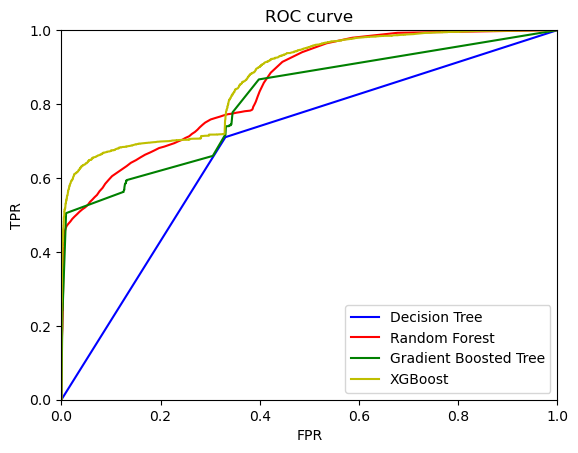

In [22]:
# Calculate probabilities
DTpredicted_probs = DT.predict_proba(drcat1_features)
RFpredicted_probs = RF.predict_proba(drcat1_features)
GBTpredicted_probs = GBT.predict_proba(drcat1_features)
XGBpredicted_probs = XGB.predict_proba(drcat1_features)

DT_fpr, DT_tpr, _ = roc_curve(drcat1_ylist, DTpredicted_probs[:,1])
RF_fpr, RF_tpr, _ = roc_curve(drcat1_ylist, RFpredicted_probs[:,1]) 
GBT_fpr, GBT_tpr, _ = roc_curve(drcat1_ylist, GBTpredicted_probs[:,1])
XGB_fpr, XGB_tpr, _ = roc_curve(drcat1_ylist, XGBpredicted_probs[:,1])

plt.plot(DT_fpr, DT_tpr, 'b', label="Decision Tree")
plt.plot(RF_fpr, RF_tpr, 'r', label="Random Forest")
plt.plot(GBT_fpr, GBT_tpr, 'g', label="Gradient Boosted Tree")
plt.plot(XGB_fpr, XGB_tpr, 'y', label="XGBoost")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()

In [23]:
ROCresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC-AUC Score': [roc_auc_score(drcat1_ylist, DTpredicted_probs[:,1]), roc_auc_score(drcat1_ylist, RFpredicted_probs[:,1]), roc_auc_score(drcat1_ylist, GBTpredicted_probs[:,1]), roc_auc_score(drcat1_ylist, XGBpredicted_probs[:,1])],
    
}
ROCresults_df = pd.DataFrame(ROCresults)
display(ROCresults_df)

,Method,ROC-AUC Score
0,Decision Tree,0.689879
1,Random Forest,0.850719
2,Gradient Boosting,0.810881
3,XGBoost,0.870056


As we expect, performance is worse when evaluating on a general dataset but with accuracy scores as high as 0.779 and ROC-AUC scores as high as 0.870 we are still getting quite impressive results to say the models were only trained on two prompts and two LLMs.

These results pose the question: Are we better off just making topic specific AI detection models, such as the acedemic science writing example, or should we strive to make a generalized model that performs well across all topics? To test this we will now re-train the models on the "main" dataset and then test on the small dataset

In [24]:
X_features = []
X_features = feature_appender(maindata, 0)

In [25]:
y_list = []
for essay in maindata:
    y_list.append(essay[1])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_list, test_size=0.2, random_state=42)

In [27]:
# Create Models
DT = DecisionTreeClassifier(random_state = 1)
RF = RandomForestClassifier(random_state = 1)
GBT = GradientBoostingClassifier(random_state = 1)
XGB = XGBClassifier(random_state = 1)

# Train models
DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
GBT.fit(X_train, y_train)
XGB.fit(X_train, y_train)

# Make predictions
DTpredicted = DT.predict(X_test)
RFpredicted = RF.predict(X_test)
GBTpredicted = GBT.predict(X_test)
XGBpredicted = XGB.predict(X_test)

In [28]:
# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Trees', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, DTpredicted), accuracy_score(y_test, RFpredicted), accuracy_score(y_test, GBTpredicted), accuracy_score(y_test, XGBpredicted)],
    'Precision': [precision_score(y_test, DTpredicted, average='weighted'), precision_score(y_test, RFpredicted, average='weighted'), precision_score(y_test, GBTpredicted, average='weighted'), precision_score(y_test, XGBpredicted, average='weighted')],
    'Recall': [recall_score(y_test, DTpredicted, average='weighted'), recall_score(y_test, RFpredicted, average='weighted'), recall_score(y_test, GBTpredicted, average='weighted'), recall_score(y_test, XGBpredicted, average='weighted')],
    'F1 Score': [f1_score(y_test, DTpredicted, average='weighted'), f1_score(y_test, RFpredicted, average='weighted'), f1_score(y_test, GBTpredicted, average='weighted'), f1_score(y_test, XGBpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Trees,0.910276,0.910374,0.910276,0.910321
1,Random Forest,0.950249,0.950368,0.950249,0.950058
2,Gradient Boosting,0.946818,0.946761,0.946818,0.946697
3,XGBoost,0.957454,0.957407,0.957454,0.957411


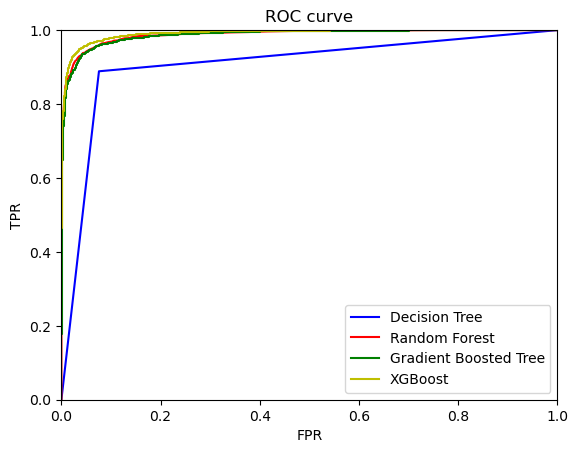

In [29]:
# Calculate probabilities
DTpredicted_probs = DT.predict_proba(X_test)
RFpredicted_probs = RF.predict_proba(X_test)
GBTpredicted_probs = GBT.predict_proba(X_test)
XGBpredicted_probs = XGB.predict_proba(X_test)

DT_fpr, DT_tpr, _ = roc_curve(y_test, DTpredicted_probs[:,1])
RF_fpr, RF_tpr, _ = roc_curve(y_test, RFpredicted_probs[:,1]) 
GBT_fpr, GBT_tpr, _ = roc_curve(y_test, GBTpredicted_probs[:,1])
XGB_fpr, XGB_tpr, _ = roc_curve(y_test, XGBpredicted_probs[:,1])

plt.plot(DT_fpr, DT_tpr, 'b', label="Decision Tree")
plt.plot(RF_fpr, RF_tpr, 'r', label="Random Forest")
plt.plot(GBT_fpr, GBT_tpr, 'g', label="Gradient Boosted Tree")
plt.plot(XGB_fpr, XGB_tpr, 'y', label="XGBoost")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()

In [30]:
ROCresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC-AUC Score': [roc_auc_score(y_test, DTpredicted_probs[:,1]), roc_auc_score(y_test, RFpredicted_probs[:,1]), roc_auc_score(y_test, GBTpredicted_probs[:,1]), roc_auc_score(y_test, XGBpredicted_probs[:,1])],
    
}
ROCresults_df = pd.DataFrame(ROCresults)
display(ROCresults_df)

,Method,ROC-AUC Score
0,Decision Tree,0.906459
1,Random Forest,0.987877
2,Gradient Boosting,0.986369
3,XGBoost,0.991028


These out of the box scores are very impressive on the general dataset as there is lots of room for improvement in the tuning of the models and the feature development. We will now check to see how well these models generalize to the topic specific dataset.

In [31]:
drcat1_features = []
drcat1_features = feature_appender(essays, 2)

In [32]:
drcat1_ylist = []
for essay in essays:
    drcat1_ylist.append(essay[3])

In [33]:
# Make predictions
DTpredicted = DT.predict(drcat1_features)
RFpredicted = RF.predict(drcat1_features)
GBTpredicted = GBT.predict(drcat1_features)
XGBpredicted = XGB.predict(drcat1_features)

# Initialize dictionaries to store the results
results = {
    'Method': ['Decision Trees', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [accuracy_score(drcat1_ylist, DTpredicted), accuracy_score(drcat1_ylist, RFpredicted), accuracy_score(drcat1_ylist, GBTpredicted), accuracy_score(drcat1_ylist, XGBpredicted)],
    'Precision': [precision_score(drcat1_ylist, DTpredicted, average='weighted'), precision_score(drcat1_ylist, RFpredicted, average='weighted'), precision_score(drcat1_ylist, GBTpredicted, average='weighted'), precision_score(drcat1_ylist, XGBpredicted, average='weighted')],
    'Recall': [recall_score(drcat1_ylist, DTpredicted, average='weighted'), recall_score(drcat1_ylist, RFpredicted, average='weighted'), recall_score(drcat1_ylist, GBTpredicted, average='weighted'), recall_score(drcat1_ylist, XGBpredicted, average='weighted')],
    'F1 Score': [f1_score(drcat1_ylist, DTpredicted, average='weighted'), f1_score(drcat1_ylist, RFpredicted, average='weighted'), f1_score(drcat1_ylist, GBTpredicted, average='weighted'), f1_score(drcat1_ylist, XGBpredicted, average='weighted')]
}

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the results table with rounded values (6 decimal places)
pd.set_option("display.precision", 6)
display(results_df)

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Trees,0.999519,0.999519,0.999519,0.999519
1,Random Forest,0.999519,0.999519,0.999519,0.999519
2,Gradient Boosting,0.991819,0.991911,0.991819,0.991834
3,XGBoost,0.998556,0.998557,0.998556,0.998557


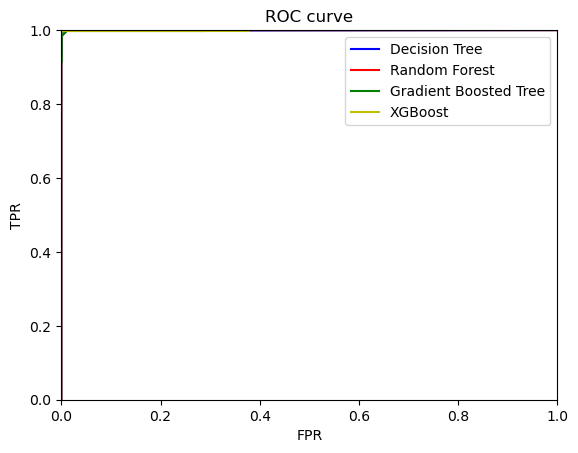

In [34]:
# Calculate probabilities
DTpredicted_probs = DT.predict_proba(drcat1_features)
RFpredicted_probs = RF.predict_proba(drcat1_features)
GBTpredicted_probs = GBT.predict_proba(drcat1_features)
XGBpredicted_probs = XGB.predict_proba(drcat1_features)

DT_fpr, DT_tpr, _ = roc_curve(drcat1_ylist, DTpredicted_probs[:,1])
RF_fpr, RF_tpr, _ = roc_curve(drcat1_ylist, RFpredicted_probs[:,1]) 
GBT_fpr, GBT_tpr, _ = roc_curve(drcat1_ylist, GBTpredicted_probs[:,1])
XGB_fpr, XGB_tpr, _ = roc_curve(drcat1_ylist, XGBpredicted_probs[:,1])

plt.plot(DT_fpr, DT_tpr, 'b', label="Decision Tree")
plt.plot(RF_fpr, RF_tpr, 'r', label="Random Forest")
plt.plot(GBT_fpr, GBT_tpr, 'g', label="Gradient Boosted Tree")
plt.plot(XGB_fpr, XGB_tpr, 'y', label="XGBoost")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()

In [35]:
ROCresults = {
    'Method': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC-AUC Score': [roc_auc_score(drcat1_ylist, DTpredicted_probs[:,1]), roc_auc_score(drcat1_ylist, RFpredicted_probs[:,1]), roc_auc_score(drcat1_ylist, GBTpredicted_probs[:,1]), roc_auc_score(drcat1_ylist, XGBpredicted_probs[:,1])],
    
}
ROCresults_df = pd.DataFrame(ROCresults)
display(ROCresults_df)

,Method,ROC-AUC Score
0,Decision Tree,0.999289
1,Random Forest,0.999812
2,Gradient Boosting,0.999353
3,XGBoost,0.999462


The models trained on the general dataset generalise to the topic specific dataset perfectly, encouraging us that it is possible to create a model that can detct AI generated text in any context.

These results are far from conclusive. When submitting these models to a Kaggle competition found at https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview they were unable to achive ROC-AUC scores above 0.7 despite the test set supposedly being very similar to the test set we are using here. This is evidence of very poor generalisation. It's possible that the two prompts used in our test set are also prompts used in the generalised set we used for training which could be a reason for the too good to be true results.

A different key take away from this analysis is how easy it is to create accurate out of the box models with basic feature engineering, especially when working in a specific domian with limited prompts. The models only require very few samples to train on and can achieve very high accuracy supporting the case that we should just train AI text detection models for specific domains or topics.